<img src="../images/content_recommender.png" alt="1"
	title="" width="150" height="100" style="float:right;" >
<h4>Content recommender algorithms are given user preferences for items and recommend similar items based on a domain-specific notion of item similarity</h4</img>

Compare features of products with the product user liked/purchased.

1.Cosine similarites
2. K means clustering

In [217]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
lemmatizer = WordNetLemmatizer()
import regex as re


In [218]:
ds = pd.read_csv("../data/cleaned_books.csv") 
ds.shape

(9964, 12)

In [ ]:
ds = pd.get_dummies(ds, columns=['authors'])
ds.head(1)

In [ ]:
ds['title_description'] = ds['title'] + " " + ds['description']
def create_bag_of_words(msg):
    #1 remove anything other than alphabets
    letters_only = re.sub("[^a-zA-Z]", " ", msg) # Remove non-letters.
    words = letters_only.lower().split()  #Convert to lower case, split into individual words.
    ps= PorterStemmer()
    base_words =[ps.stem(w) for w  in words] 
    return(" ".join(base_words))# 6. Join the words back into one string separated by space, 
ds['title_description'] = ds['title_description'].apply(create_bag_of_words)

In [223]:
tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(ds['title_description'])
cosine_similarities = cosine_similarity(tfidf_matrix,tfidf_matrix)
cosine_similarities.shape

(9964, 9964)

In [224]:
ds.dtypes

title                                  object
book_id                                 int64
goodreads_book_id                       int64
original_publication_year             float64
language_code                          object
                                       ...   
authors_نور عبدالمجيد                   uint8
authors_ياسر حارب                       uint8
authors_يوسف زيدان                      uint8
authors_يوسف زيدان, Youssef Ziedan      uint8
title_description                      object
Length: 4654, dtype: object

In [225]:
def search_by_title(title):
    return ds.loc[ds['title'].str.lower().str.contains(title),['title','book_id']]

def book_title(book_id):
    return ds.loc[ds['book_id'] == book_id,'title'].values[0]

def build_nlp_content_recommender():
    #min_df : ignore terms that have a document frequency strictly lower than the given threshold
    tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), min_df=0, stop_words='english')
    tfidf_matrix = tf.fit_transform(ds['title_description'])
    cosine_similarities = cosine_similarity(tfidf_matrix,tfidf_matrix)

def recommend_top_books(book_id, ds,cosine_similarities,n=2):
    idx =ds.index[ds['book_id'] ==book_id].values[0]
    
    closet_match_indices = cosine_similarities[idx].argsort()[:-10:-1] #stores 5 most similar books
    similar_items = [(np.round(cosine_similarities[idx][i],2), ds['book_id'][i],book_id) for i in closet_match_indices]
    print(f"You may also like to read: ")
    for rec in similar_items:
        print(f"-> {rec[2]} {book_title(rec[1])} score: {rec[0]} ")

In [226]:
# this takes long time to build similarity matrix
results =build_nlp_content_recommender() 

In [227]:
#3275 -Harry Potter Boxed Set, Books 1-5 (Harry Potter, #1-5)score
#8084 - Naked Economics: Undressing the Dismal Science
#3054 -Harry Potter and the Chamber of Secrets: Sheet Music for Flute with C.Dscore
#22
recommend_top_books(3275,ds,cosine_similarities,10)

You may also like to read: 
-> 3275 Harry Potter Boxed Set, Books 1-5 (Harry Potter, #1-5) score: 1.0 
-> 3275 The Harry Potter Collection 1-4 (Harry Potter, #1-4) score: 0.57 
-> 3275 Harry Potter and the Order of the Phoenix (Harry Potter, #5, Part 1) score: 0.56 
-> 3275 Harry Potter and the Goblet of Fire (Harry Potter, #4) score: 0.44 
-> 3275 Harry Potter Boxset (Harry Potter, #1-7) score: 0.44 
-> 3275 Harry Potter and the Chamber of Secrets (Harry Potter, #2) score: 0.4 
-> 3275 Harry Potter and the Cursed Child - Parts One and Two (Harry Potter, #8) score: 0.38 
-> 3275 Harry Potter Collection (Harry Potter, #1-6) score: 0.37 
-> 3275 Harry Potter and the Deathly Hallows (Harry Potter, #7) score: 0.33 


In [274]:
recommend_top_books(2855,ds,cosine_similarities,10)

You may also like to read: 
-> 2855 #GIRLBOSS score: 1.0 
-> 2855 الطنطورية score: 0.09 
-> 2855 بيكاسو وستاربكس score: 0.09 
-> 2855 ثلاثية غرناطة score: 0.09 
-> 2855 درخت زیبای من score: 0.09 
-> 2855 ساق البامبو score: 0.08 
-> 2855 السنجة score: 0.08 
-> 2855 Горе от ума score: 0.07 
-> 2855 استمتع بحياتك score: 0.07 


In [273]:
x= search_by_title('girl')
#ds[ds['book_id'] ==8084 ]
x

,title,book_id
2,#GIRLBOSS,2855
152,A Girl Like You,8292
153,A Girl Named Zippy,3568
154,"A Girl of the Limberlost (Limberlost, #2)",7833
454,"All I Want is Everything (Gossip Girl, #3)",7546
...,...,...
9857,"You Know You Love Me (Gossip Girl, #2)",6402
9865,"You're the One That I Want (Gossip Girl, #6)",6391
9882,"Zita the Spacegirl (Zita the Spacegirl, #1)",8948
9891,for colored girls who have considered suicide/...,3872


In [243]:
###  K means clustering
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [244]:
ds['is_ebook'] = ds['is_ebook'].astype(int) 

In [247]:
#len(ds['authors'].unique())

In [248]:
ds['original_publication_year']=ds['original_publication_year'].fillna(0)
ds['original_publication_year'].isna().sum()
ds['original_publication_year']= ds['original_publication_year'].astype(int)

In [249]:
ds['title_description'] = ds['title_description'].replace({"[^A-Za-z0-9 ]+": ""}, regex=True)

In [251]:
col_list =['num_pages', 'is_ebook', 'original_publication_year','average_rating']
X = ds.loc[:, col_list]
sc = StandardScaler()
X_sc = sc.fit_transform(X)

In [252]:
df = pd.DataFrame(X, columns= col_list)

kmeans = KMeans(n_clusters=3)

y = kmeans.fit_predict(X_sc)

df['Cluster'] = y

In [253]:
df['Cluster'].value_counts()

0    9277
1     629
2      58
Name: Cluster, dtype: int64

In [254]:
# Check out centroids
kmeans.cluster_centers_,kmeans.labels_

(array([[  0.017831  ,  -0.26001838,   0.06486782,  -0.01972745],
        [ -0.24125042,   3.84588198,   0.18658096,   0.27874731],
        [ -0.23571885,  -0.11843561, -12.39893459,   0.13240494]]),
 array([0, 0, 0, ..., 0, 0, 0], dtype=int32))

### elbow method to determine the optimal number of clusters for k-means clustering

,k,inertia,silhouette
0,2,29783.824064,0.623431
1,3,20850.791845,0.639402
2,4,15035.474485,0.349683
3,5,11345.683651,0.379782
4,6,9651.222626,0.337371
5,7,8355.622660,0.330966
6,8,7203.939996,0.339904
7,9,6522.668816,0.326435
8,10,6020.075623,0.318374
9,11,5581.877014,0.325351


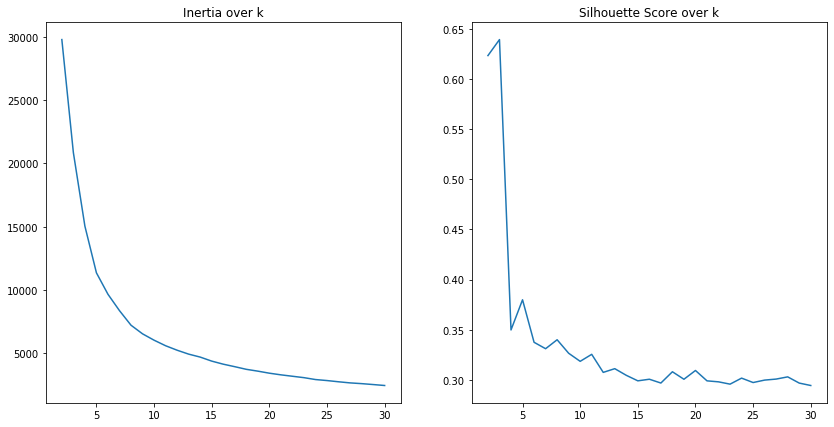

In [255]:
#Inertia - sum of squared errors for each cluster.
#low inertia = dense cluster

#silhoutte score -measure of how far apart clusters are. high Silhouette=> well separated clusters
def find_optimal_k(X_sc):
    scores = []
    for k in range(2, 31):
        cl = KMeans(n_clusters=k)
        cl.fit(X_sc)
        inertia = cl.inertia_  #
        sil = silhouette_score(X_sc, cl.labels_)
        scores.append([k, inertia, sil])  
    score_df = pd.DataFrame(scores)
    score_df.columns = ['k', 'inertia', 'silhouette']
    fig, axes = plt.subplots(1, 2, figsize=(14, 7))
    axes[0].plot(score_df.k, score_df.inertia)
    axes[0].set_title('Inertia over k')
    axes[1].plot(score_df.k, score_df.silhouette);
    axes[1].set_title('Silhouette Score over k')
    return score_df

find_optimal_k(X_sc)

 Notice how the elbow chart does not have a clear elbow. Instead, we see a fairly smooth curve, and it's unclear what is the best value of k to choose. In cases like this, we might try a different method for determining the optimal k, such as computing silhouette scores, or we might reevaluate whether clustering is the right thing to do on our data.

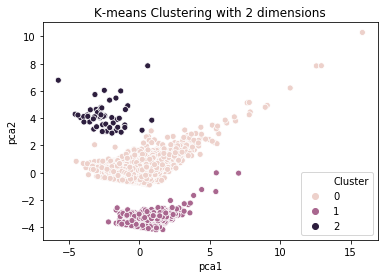

In [256]:
reduced_data = PCA(n_components=2).fit_transform(X_sc)
results = pd.DataFrame(reduced_data,columns=['pca1','pca2'])
sns.scatterplot(x="pca1", y="pca2", hue=df['Cluster'], data=results)
plt.title('K-means Clustering with 2 dimensions')
plt.show()

In [257]:
#. Lets Apply K means clustering on the text data

In [258]:
tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(ds['title_description'])
sc = StandardScaler()
X_sc = sc.fit_transform(X)

In [259]:
#Choosing k = 5
kmeans = KMeans(n_clusters=5)
y = kmeans.fit_predict(X_sc)
df['Cluster'] = y

In [260]:
df['Cluster'].value_counts()

3    4823
1    3720
0     739
2     625
4      57
Name: Cluster, dtype: int64

,k,inertia,silhouette
0,2,29783.824064,0.623431
1,3,20850.791845,0.639402
2,4,15035.413959,0.349736
3,5,11345.877084,0.379947
4,6,9649.978142,0.336487
5,7,8356.263953,0.329808
6,8,7203.934150,0.339904
7,9,6523.754114,0.325970
8,10,6020.069268,0.318374
9,11,5581.897632,0.325334


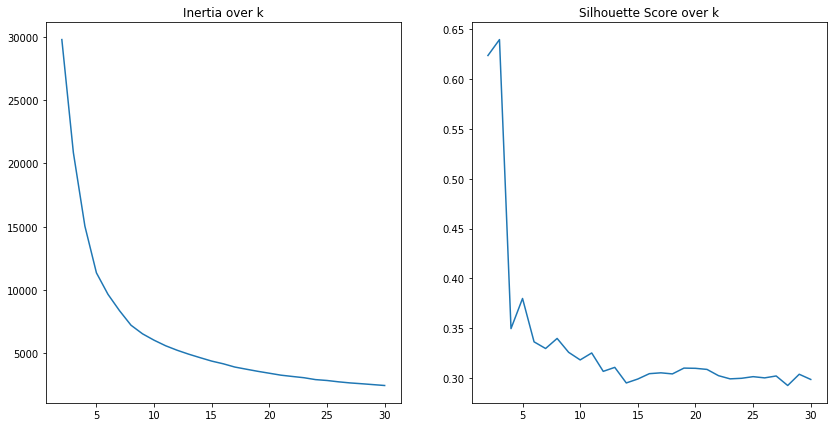

In [261]:
find_optimal_k(X_sc)

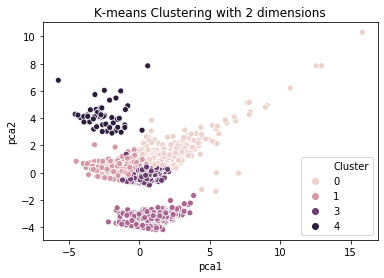

In [264]:
reduced_data = PCA(n_components=2).fit_transform(X_sc)
results = pd.DataFrame(reduced_data,columns=['pca1','pca2'])

sns.scatterplot(x="pca1", y="pca2", hue=df['Cluster'], data=results)
plt.title('K-means Clustering with 2 dimensions')
plt.show()

In [265]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [266]:
preprocess = ColumnTransformer(
    [
     ('authors', OneHotEncoder(dtype='int', handle_unknown='ignore'), ['authors']),
     ('title_description', TfidfVectorizer(analyzer='word', ngram_range=(1, 2), min_df=0, stop_words='english'), 'title_description'),
    ],
    remainder='passthrough')

In [268]:
kmeans = KMeans(n_clusters=5)
y = kmeans.fit_predict(X_sc)
ds['Cluster'] = y

In [269]:

cluster_df.head(1)

,title,book_id,goodreads_book_id,original_publication_year,language_code,average_rating,ratings_count,description,num_pages,is_ebook,...,authors_4633,authors_4634,authors_4635,authors_4636,authors_4637,authors_4638,authors_4639,authors_4640,authors_4641,Cluster
5,"1,000 Places to See Before You Die",2618,11525,2003.0,NaN,3.83,33025,"Around the World, continent by continent, here...",992.0,False,...,0,0,0,0,0,0,0,0,0,3


In [270]:
    c= ds.loc[ds['book_id'] ==3275,'Cluster'].values[0]

In [ ]:
    c= ds.loc[ds['book_id'] ==3275,'Cluster'].values[0]

In [275]:
def recommend_top_books_incluster(book_id, ds,n=2):
    c = ds.loc[ds['book_id'] ==book_id,'Cluster'].values[0]
    cluster_df = ds[ds['Cluster']==c]
    cluster_df.reset_index(inplace=True)
    print(f"cluster for {book_id} is {c}  {len(cluster_df['title_description'])}")
    
    tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), min_df=0, stop_words='english')
    tfidf_matrix = tf.fit_transform(cluster_df['title_description'])
    
    cosine_similarities = cosine_similarity(tfidf_matrix,tfidf_matrix)
    idx =cluster_df.index[cluster_df['book_id'] ==book_id].values[0]
    
    closet_match_indices = cosine_similarities[idx].argsort()[:-5:-1] 

    similar_items = [(np.round(cosine_similarities[idx][i],2), ds['book_id'][i],book_id) for i in closet_match_indices]
    print(f"You may also like to read: ")
    for rec in similar_items:
        print(f"-> {rec[2]} {book_title(rec[1])} score: {rec[0]} ")
        
recommend_top_books_incluster(2855,ds)


cluster for 2855 is 1  3729
You may also like to read: 
-> 2855 #GIRLBOSS score: 1.0 
-> 2855 La Dame aux Camélias score: 0.1 
-> 2855 L is for Lawless (Kinsey Millhone, #12) score: 0.09 
-> 2855 Lady Audley's Secret score: 0.07 


In [349]:
#https://datascience.stackexchange.com/questions/48693/perform-k-means-clustering-over-multiple-columns
https://www.kaggle.com/zygmunt/goodbooks-10k#tags.csv

https://www.kdnuggets.com/2019/11/content-based-recommender-using-natural-language-processing-nlp.html


https://towardsdatascience.com/how-to-build-from-scratch-a-content-based-movie-recommender-with-natural-language-processing-25ad400eb243

https://towardsdatascience.com/my-journey-to-building-book-recommendation-system-5ec959c41847


https://www.linkedin.com/pulse/content-based-recommender-engine-under-hood-venkat-raman/

In [ ]:
    tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), min_df=0, stop_words='english')
    tfidf_matrix = tf.fit_transform(ds['title_description'])
    cosine_similarities = cosine_similarity(tfidf_matrix,tfidf_matrix)